In [2]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from scipy.spatial import distance_matrix
from tqdm import tqdm
import pymc as pm
import pytensor.tensor as at
import arviz as az
from scipy.stats import binned_statistic

os.chdir(os.getcwd())



#load geolocation data and subset by Madrid
gdf = gpd.read_file("./data/zonificacion_municipios.shp")
gdf = gdf.to_crs('+proj=cea')

gdf.reset_index(inplace=True, drop=True)
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
gdf['centroid'] = gdf["geometry"].centroid.to_crs(gdf.crs)

names = pd.read_csv("./data/nombres_municipios.csv", sep="|")

mad = gdf[gdf.ID.str.startswith("28")] #Madrid municipios start with 28

data = pd.read_csv("data_jan_ave.csv")

pob = pd.read_csv("./data/poblacion.csv", sep="|")
pob = pob[pob.municipio.isin(data.ID.unique())]
pob = pob.drop_duplicates('municipio') 
pob['ID'] = pob.municipio

data

,origen,destino,fecha,periodo,residencia,viajes,viajes_km,visitors,ID,centroid_dest,geometry,coords,centroid,distance,dist_km
0,28002,28002,56353463554,33874,78036,15308.290178,30427.882278,2787,28002,POINT (-387410.2040995159 4124328.829936072),POLYGON ((-389198.21407973714 4126968.84917661...,"(-387860.5865608195, 4124672.523105364)",POINT (-387410.2040995159 4124328.829936072),0.000000,0.000000
1,28002,28004,20220106,12,28,2.032000,114.097000,1,28002,POINT (-444081.866951179 4099631.00032739),POLYGON ((-389198.21407973714 4126968.84917661...,"(-387860.5865608195, 4124672.523105364)",POINT (-387410.2040995159 4124328.829936072),59100.150672,59.100151
2,28002,28005,47598153639,29105,65912,10518.049000,94151.952000,2354,28002,POINT (-375158.2138054491 4121857.2703169133),POLYGON ((-389198.21407973714 4126968.84917661...,"(-387860.5865608195, 4124672.523105364)",POINT (-387410.2040995159 4124328.829936072),7333.774507,7.333775
3,28002,28006,12758893494,7395,17668,1879.844000,25429.052000,631,28002,POINT (-404102.35500715533 4125226.1190320468),POLYGON ((-389198.21407973714 4126968.84917661...,"(-387860.5865608195, 4124672.523105364)",POINT (-387410.2040995159 4124328.829936072),13128.752121,13.128752
4,28002,28007,1617609375,943,2240,158.259000,5668.471000,80,28002,POINT (-427159.83455845463 4110320.589082486),POLYGON ((-389198.21407973714 4126968.84917661...,"(-387860.5865608195, 4124672.523105364)",POINT (-387410.2040995159 4124328.829936072),39263.905053,39.263905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,28170_AM,28037_AM,20220124,14,28,5.544000,468.027000,1,28170_AM,POINT (-502086.54440277617 4102139.654877107),MULTIPOLYGON (((-384439.39973564463 4089957.87...,"(-389599.59814522986, 4089434.4588928865)",POINT (-391132.7748813631 4090116.3956021704),103673.405150,103.673405
12295,28170_AM,28042_AM,40440262,26,56,7.572000,479.236000,2,28170_AM,POINT (-466359.52844335453 4116601.729458539),MULTIPOLYGON (((-384439.39973564463 4089957.87...,"(-389599.59814522986, 4089434.4588928865)",POINT (-391132.7748813631 4090116.3956021704),71972.795972,71.972796
12296,28170_AM,28095,40440234,31,56,11.549000,692.475000,2,28170_AM,POINT (-459749.25372621644 4117236.96301883),MULTIPOLYGON (((-384439.39973564463 4089957.87...,"(-389599.59814522986, 4089434.4588928865)",POINT (-391132.7748813631 4090116.3956021704),66072.368784,66.072369
12297,28170_AM,28178_AM,20220105,18,28,7.235000,375.117000,1,28170_AM,POINT (-457926.59516478673 4110426.745917801),MULTIPOLYGON (((-384439.39973564463 4089957.87...,"(-389599.59814522986, 4089434.4588928865)",POINT (-391132.7748813631 4090116.3956021704),61971.247852,61.971248


C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1300276487.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdf_obs = data.groupby(['origen', 'destino']).mean()
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1300276487.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1300276487.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matpl

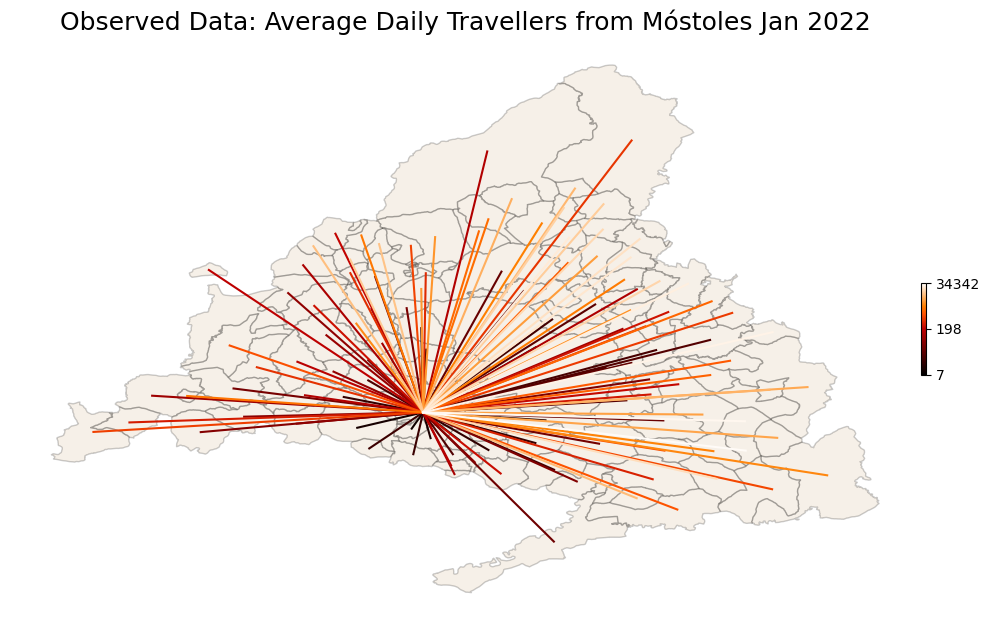

In [3]:
#################### Observed Data ##############################
### Plot Survey data observed
Tdf_obs = data.groupby(['origen', 'destino']).mean()
Tdf_obs = pd.pivot_table(Tdf_obs, index='origen', columns='destino', values='visitors')
Ndf = Tdf_obs[Tdf_obs.index=="28092"].T
Ndf['ID'] = Ndf.index
Ndf = Ndf.replace(np.nan,0)
madg = pd.merge(mad,Ndf)
madg = madg.sort_values(by="28092", ascending=False)
madg.reset_index(inplace=True, drop=True)

max_val = int(max(madg["28092"]))
mid_val = int(np.median(madg["28092"]))
min_val = int(min(madg["28092"]))

colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
for c in range(len(madg)):
    #ch_map.set_facecolor("grey")
    muni_dest = madg.ID[c]
    orig = "28092" 
    dest_coord = mad[mad.ID==muni_dest].coords.values[0]
    orig_coord = mad[mad.ID==orig].coords.values[0]
    x = (dest_coord[0], orig_coord[0])
    y = (dest_coord[1], orig_coord[1])
    ch_map.plot(x,y, color=colors[c])  
cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
cbar.set_ticklabels([min_val,mid_val,max_val])
plt.title("Observed Data: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig("plot_madrid_municipio_observed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

obs = Tdf_obs.values
obs[np.isnan(obs)] = 0

100%|███████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 988.44it/s]
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\3433051862.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\3433051862.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\3433051862.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal sp

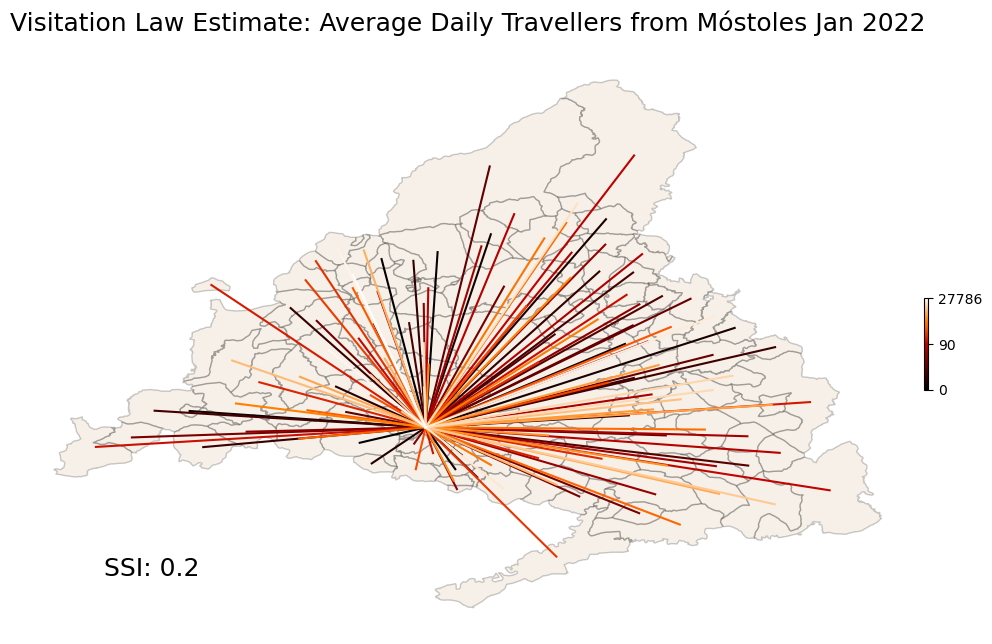

In [4]:

#create distance matrix for radiuses R
xy = np.array([np.array(mad.centroid.values[i].xy) for i in tqdm(range(len(mad)))]).T[0]
D = distance_matrix(xy.T, xy.T) + 0.000000001 #distance matrix in meters

R = D/1000  #radiuses in km

A = 2*np.pi*R

N = pd.pivot_table(data, index='origen', columns='destino', values='visitors').values #Number of visitors
N[np.isnan(N)] = 0

rho = N/A

F = pd.pivot_table(data, index='origen', columns='destino', values='viajes').values #frequency of visitation sum
F[np.isnan(F)] = 0.000000001

fmin = F.mean()/N.mean()/31 #once per day
fmax = F.mean()/N.mean() #max daily per person

mu = rho*(R*1)**2
Vij = (mu*A)/(np.log(fmax/fmin)*R**2) * 31

##for some reason this approx does not work
# F =  pd.pivot_table(data, index='origen', columns='destino', values='viajes')
# N =  pd.pivot_table(data, index='origen', columns='destino', values='visitors')
# fmax = (F/N)
#fmax = F.T['28092'].values/N.T['28092'].values
# rhoj = pob.poblacion.values/(mad.geometry.area.values/1e6)
# rj = (mad.geometry.area.values/1e6)/(2*np.pi)
# muj = rhoj*(rj**2)*fmax
# Ai = mad[mad.ID=="28092"].geometry.area.values/1e6 #area origin
# rij = pd.DataFrame(R, index=data.origen.unique(), columns=data.destino.unique())
# rij = rij.T["28092"].values
# Vij = (muj*Ai)/(np.log(fmax/fmin)*rij**2)


### Plot Visitation law for Mostoles
# Ndf = pd.DataFrame({"28092":Vij, "ID":data.ID.unique()})
Tdf = pd.DataFrame(Vij, index=data.origen.unique(), columns=data.destino.unique())
Ndf = Tdf[Tdf.index=="28092"].T
Ndf['ID'] = Ndf.index
Ndf = Ndf.replace(np.nan,0)
madg = pd.merge(mad,Ndf)
madg = madg.sort_values(by="28092", ascending=False)
madg.reset_index(inplace=True, drop=True)

max_val = int(max(madg["28092"]))
mid_val = int(np.median(madg["28092"]))
min_val = int(min(madg["28092"]))

colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

SSI_vis = 2*np.sum(np.minimum(Vij[63], obs[63]))/(np.sum(Vij[63]) + np.sum(obs[63]))

ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
for c in range(len(madg)):
    #ch_map.set_facecolor("grey")
    muni_dest = madg.ID[c]
    orig = "28092" 
    dest_coord = mad[mad.ID==muni_dest].coords.values[0]
    orig_coord = mad[mad.ID==orig].coords.values[0]
    x = (dest_coord[0], orig_coord[0])
    y = (dest_coord[1], orig_coord[1])
    ch_map.plot(x,y, color=colors[c])  
cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
cbar.set_ticklabels([min_val,mid_val,max_val])
plt.text(0.1, 0.1,"SSI: "+str(round(SSI_vis, 2)), transform=ch_map.transAxes, fontsize=18)
plt.title("Visitation Law Estimate: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig("plot_madrid_municipio_visitation.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 2046.29it/s]
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1761852629.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1761852629.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))
C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_19120\1761852629.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal sp

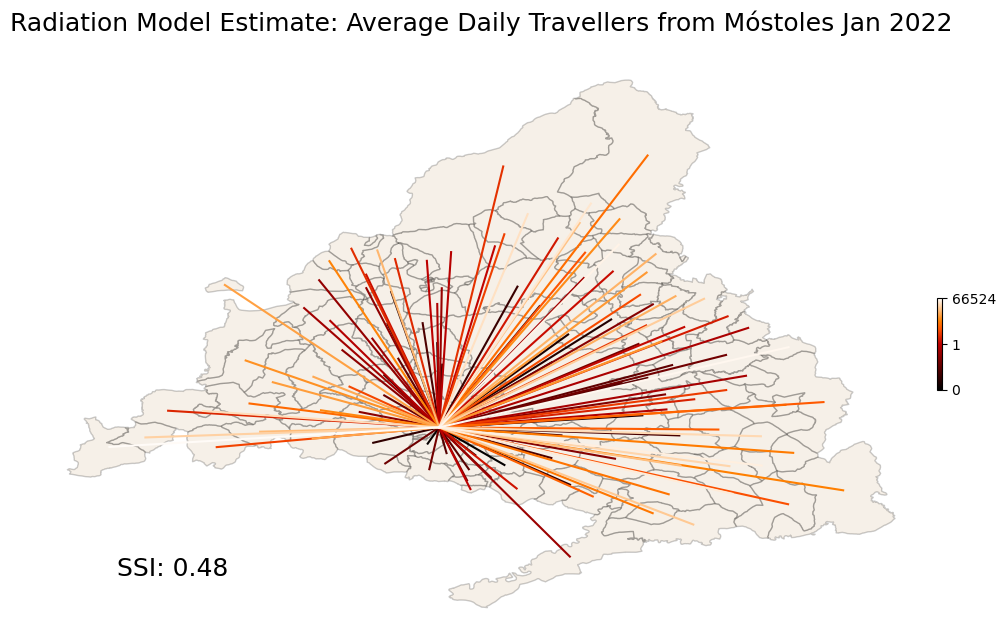

In [5]:
pob.reset_index(inplace=True, drop=True)
pobs = []
for i in tqdm(range(len(pob))):
    ori = pob.municipio[i]
    des = pob.municipio.values
    p = pob.poblacion.values
    ps = pd.DataFrame({'origen':np.repeat(ori, len(pob)), 'destino':des, 'poblacion':p})
    pobs.append(ps)
pobs = pd.concat(pobs)
P = pd.pivot_table(pobs, index='origen', columns='destino', values='poblacion')
P = P.values

## (create surrounding population matrix Sij) THIS ONE DOES NOT WORK!
def calc_pops(R,P):
    Sij0 = []
    for i in tqdm(range(R.shape[0])):
        r = R[i,:]
        s = [R[i,:]<=r[j] for j in range(R.shape[1])] #exclude places outside radius
        # calculate populations sum within radious excluding origin and destination pops 
        p = [P[i,:][s[j]].sum() -P[i,j] for j in range(R.shape[1])]
        Sij0.append(p)
    return np.array(Sij0)    
Sij = calc_pops(R,P)


N = pob.poblacion.values.sum()
Nc = data.visitors.sum() #total number of commuters over 1 month period
Mi = pob.poblacion.values #populations origin
Nj = pob.poblacion.values #populations destination
Ti = Mi*(Nc/N) #estimated flux from origin

#Radiation Model
p_num = Mi*Nj
p_den = (Mi + Sij)*(Mi + Nj + Sij)
p = p_num/p_den
Tmean = Ti*p
Tsd = np.sqrt(Ti*p*(1-p))



### Plot Radiation Model's Estimates for Mostoles
Tdf = pd.DataFrame(Tmean, index=mad.ID.unique(), columns=mad.ID.unique())
Ndf = Tdf[Tdf.index=="28092"].T
Ndf['ID'] = Ndf.index
Ndf = Ndf.replace(np.nan,0)
madg = pd.merge(mad,Ndf)
madg = madg.sort_values(by="28092", ascending=False)
madg.reset_index(inplace=True, drop=True)

max_val = int(max(madg["28092"]))
mid_val = int(np.median(madg["28092"]))
min_val = int(min(madg["28092"]))

colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

SSI_rad = 2*np.sum(np.minimum(Tmean[63], obs[63]))/(np.sum(Tmean[63]) + np.sum(obs[63]))

ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
for c in range(len(madg)):
    #ch_map.set_facecolor("grey")
    muni_dest = madg.ID[c]
    orig = "28092" 
    dest_coord = mad[mad.ID==muni_dest].coords.values[0]
    orig_coord = mad[mad.ID==orig].coords.values[0]
    x = (dest_coord[0], orig_coord[0])
    y = (dest_coord[1], orig_coord[1])
    ch_map.plot(x,y, color=colors[c])  
cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
cbar.set_ticklabels([min_val,mid_val,max_val])
plt.text(0.1, 0.1,"SSI: "+str(round(SSI_rad, 2)), transform=ch_map.transAxes, fontsize=18)
plt.title("Radiation Model Estimate: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig("plot_madrid_municipio_radiation.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [ ]:

###############################################################################
########################### Gavity Model ######################################

Mi = pob.poblacion.values[63] #populations origin
Nj = pob.poblacion.values #populations destination
Oi = data[data.origen=='28092'].viajes.values #origin's total outflow, i.e. total number of trips per unit of time (in this case daily average over a month)
muni_n = len(data.origen.unique())

##single origin version
dj = pd.DataFrame(R, index=mad.ID.unique(), columns=mad.ID.unique())
dj = dj.T['28092'].values
T = Tdf_obs.T['28092'].values
with pm.Model() as mod:
    t_s = pm.HalfNormal("t_s", 1)
    theta = pm.HalfNormal("theta", t_s, shape=muni_n)
    o_s = pm.HalfNormal("o_s", 0.5)
    omega = pm.HalfNormal("omega", o_s, shape=muni_n)
    g_s = pm.HalfNormal("g_s", 0.5)
    gamma = pm.HalfNormal("gamma", g_s, shape=muni_n)
    lam_den = (Nj**omega)*(dj**-gamma)
    lam_num = at.sum(lam_den)
    lam = pm.Deterministic("lam", theta*Mi*(lam_den/lam_num))
    alpha = pm.HalfNormal("alpha", 10)
    m = pm.NegativeBinomial("m", mu=lam, alpha=alpha, observed=T)

dag = pm.model_to_graphviz(mod)
dag.render("gravity_model_dag", format="png")
dag

#sample prior predictive
with mod:
    ppc = pm.sample_prior_predictive(1000, var_names=['m'])
ppc = ppc.stack(sample = ['chain', 'draw']).prior_predictive
ppc_m = ppc['m'].values
ppc_mean = ppc_m.mean(axis=1)
samples = np.random.randint(0, 1000, 100)
for s in samples:
    plt.plot(ppc_m[:,s], alpha=0.1, color="r")
plt.plot(ppc_m[:,s+1], alpha=0.1, color="r", label="prior predictive samples")
plt.plot(np.arange(len(ppc_mean)), ppc_mean, label="prior predictive samples mean")
plt.plot(np.arange(len(ppc_mean)), T, color='grey', linestyle=":", label="observed")
plt.legend()
plt.title("Prior Predictive Checks: Gravity Model")
plt.savefig("prior_predictive_gravity.png", dpi=300)

#sample MCMC
with mod:
    idata = pm.sample(2000, chains=4, cores=12, target_accept=0.99)


pos = idata.stack(sample = ['chain', 'draw']).posterior
pos_lam = pos['lam'].values.mean(axis=1)
Ndf =  pd.DataFrame({"28092":pos_lam})
Ndf['ID'] = data.destino.unique()
madg = pd.merge(mad,Ndf)
madg = madg.sort_values(by="28092", ascending=False)
madg.reset_index(inplace=True, drop=True)

max_val = int(max(madg["28092"]))
mid_val = int(np.median(madg["28092"]))
min_val = int(min(madg["28092"]))

colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

SSI_gra = 2*np.sum(np.minimum(pos_lam,T))/(np.sum(pos_lam) + np.sum(T))

ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
for c in range(len(madg)):
    #ch_map.set_facecolor("grey")
    muni_dest = madg.ID[c]
    orig = "28092" 
    dest_coord = mad[mad.ID==muni_dest].coords.values[0]
    orig_coord = mad[mad.ID==orig].coords.values[0]
    x = (dest_coord[0], orig_coord[0])
    y = (dest_coord[1], orig_coord[1])
    ch_map.plot(x,y, color=colors[c])  
cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
cbar.set_ticklabels([min_val,mid_val,max_val])
plt.text(0.1, 0.1,"SSI: "+str(round(SSI_gra, 2)), transform=ch_map.transAxes, fontsize=18)
plt.title("Gravity Model Estimate: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig("plot_madrid_municipio_gravity.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


#sample posterior predictive
with mod:
    ppc = pm.sample_posterior_predictive(idata, var_names=['m'])
ppc = ppc.stack(sample = ['chain', 'draw']).posterior_predictive
ppc_m = ppc['m'].values 
    
#plot posterior predictive
pos_lam = ppc_m.mean(axis=1)
Ndf =  pd.DataFrame({"28092":pos_lam})
Ndf['ID'] = data.destino.unique()
madg = pd.merge(mad,Ndf)
madg = madg.sort_values(by="28092", ascending=False)
madg.reset_index(inplace=True, drop=True)

max_val = int(max(madg["28092"]))
mid_val = int(np.median(madg["28092"]))
min_val = int(min(madg["28092"]))

colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

SSI_gra = 2*np.sum(np.minimum(pos_lam,T))/(np.sum(pos_lam) + np.sum(T))

ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
for c in range(len(madg)):
    #ch_map.set_facecolor("grey")
    muni_dest = madg.ID[c]
    orig = "28092" 
    dest_coord = mad[mad.ID==muni_dest].coords.values[0]
    orig_coord = mad[mad.ID==orig].coords.values[0]
    x = (dest_coord[0], orig_coord[0])
    y = (dest_coord[1], orig_coord[1])
    ch_map.plot(x,y, color=colors[c])  
cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
cbar.set_ticklabels([min_val,mid_val,max_val])
plt.text(0.1, 0.1,"SSI: "+str(round(SSI_gra, 2)), transform=ch_map.transAxes, fontsize=18)
plt.title("Gravity Model Predictions: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig("plot_madrid_municipio_gravity_ppc.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

#save summary of mcmc posteriors
summ = az.summary(idata, hdi_prob=0.9)
summ.to_csv("gravity_model_hierarchical_summary.csv")

# Mi = pob.poblacion.values #populations origin
# Nj = pob.poblacion.values #populations destination
# Oi = F.mean(axis=1) #origin's total outflow, i.e. total number of trips per unit of time (in this case daily average over a month)
# muni_n = len(data.origen.unique())

# obs_sparse = data.groupby(['origen', 'destino']).mean()
# obs_sparse = pd.pivot_table(obs_sparse, index='origen', columns='destino', values='visitors')

# with pm.Model() as mod:
#     t_s = pm.HalfNormal("t_s", 0.1)
#     theta = pm.HalfNormal("theta", t_s)#, shape=muni_n)
#     o_s = pm.HalfNormal("o_s", 0.1)
#     omega = pm.HalfNormal("omega", o_s)#, shape=muni_n)
#     g_s = pm.HalfNormal("g_s", 0.1)
#     gamma = pm.HalfNormal("gamma", g_s)#, shape=muni_n)
#     lam_den = (Nj**omega)*(R*-gamma)
#     lam_num = at.sum(lam_den, axis=1)
#     lam = pm.Deterministic("lam", theta*Mi*(lam_den/lam_num))
#     alpha = pm.HalfNormal("alpha", 0.1)
#     #m = pm.NegativeBinomial("m", mu=lam, alpha=alpha, observed=Tdf_obs.values)
#     psi = pm.Beta("psi", 1,1)
#     m = pm.ZeroInflatedNegativeBinomial("m", mu=lam, alpha=alpha, psi=psi, observed=N)
    
# dag = pm.model_to_graphviz(mod)
# dag.render("gravity_model_dag", format="png")
# dag

# with mod:
#     ppc = pm.sample_prior_predictive(1000, var_names=['m'])
# ppc = ppc.stack(sample = ['chain', 'draw']).prior_predictive
# ppc_m = ppc['m'].values
# obs_df = Tdf_obs
# obs_df['id'] = np.arange(len(obs_df))
# idx = obs_df[obs_df.index=="28092"].id.values[0]
# ppc_mean = ppc_m[63].mean(axis=1)
# ppc_sd = ppc_m[63].std(axis=1)
# plt.plot(np.arange(len(ppc_mean)), ppc_mean)
# for s in range(ppc_m.shape[1]):
#     plt.plot(ppc_m[63][:,s], alpha=0.3, color="r")

# ##sample
# with mod:
#     idata = pm.sample(1000, chains=4, cores=12)#, target_accept=0.99)
    
# pos = idata.stack(sample = ['chain', 'draw']).posterior

# pos_lam = pos['lam'].values.mean(axis=2)

# ## Plot Gravity Model's Estimates from Mostoles
# Tdf =  pd.DataFrame(pos_lam, index=data.origen.unique(), columns=data.destino.unique())
# Ndf = Tdf[Tdf.index=="28092"].T
# Ndf['ID'] = Ndf.index
# Ndf = Ndf.replace(np.nan,0)
# madg = pd.merge(mad,Ndf)
# madg = madg.sort_values(by="28092", ascending=False)
# madg.reset_index(inplace=True, drop=True)

# max_val = int(max(madg["28092"]))
# mid_val = int(np.median(madg["28092"]))
# min_val = int(min(madg["28092"]))

# colors = np.array([mpl.cm.get_cmap('gist_heat')(x/len(madg)) for x in range(len(madg))])
# sm = plt.cm.ScalarMappable(cmap=mpl.cm.get_cmap('gist_heat'))

# SSI_gra = 2*np.sum(np.minimum(pos_lam,obs))/(np.sum(pos_lam) + np.sum(obs))

# ch_map = mad.plot(figsize=(10,20), color="tan", alpha=0.2, edgecolor="k")
# for c in range(len(madg)):
#     #ch_map.set_facecolor("grey")
#     muni_dest = madg.ID[c]
#     orig = "28092" 
#     dest_coord = mad[mad.ID==muni_dest].coords.values[0]
#     orig_coord = mad[mad.ID==orig].coords.values[0]
#     x = (dest_coord[0], orig_coord[0])
#     y = (dest_coord[1], orig_coord[1])
#     ch_map.plot(x,y, color=colors[c])  
# cbar = plt.colorbar(sm,fraction=0.005, pad=0.001)
# cbar.set_ticklabels([min_val,mid_val,max_val])
# plt.text(0.1, 0.1,"SSI: "+str(round(SSI_gra, 2)), transform=ch_map.transAxes, fontsize=18)
# plt.title("Gravity Model Estimate: Average Daily Travellers from Móstoles Jan 2022", fontsize=18)
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("plot_madrid_municipio_gravity.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()
# plt.close()

# #save summary of mcmc posteriors
# summ = az.summary(idata, hdi_prob=0.9)
# summ.to_csv("gravity_model_simple_summary.csv")

Sampling: [alpha, g_s, gamma, m, o_s, omega, t_s, theta]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 12 jobs)
NUTS: [t_s, theta, o_s, omega, g_s, gamma, alpha]


In [ ]:

################ Comparison Plot #####################
V_obs = pd.pivot_table(data, index='origen', columns='destino', values='visitors').values #Number of visitors
V_obs[np.isnan(V_obs)] = 0
V_obs = V_obs[63]
V_vis = pd.DataFrame(Vij, index=data.origen.unique(), columns=data.destino.unique())
V_vis = V_vis.T["28092"].values
V_rad = pd.DataFrame(Tmean, index=data.origen.unique(), columns=data.destino.unique())
V_rad = V_rad.T["28092"].values
# V_gra = pd.DataFrame(pos_lam, index=data.origen.unique(), columns=data.destino.unique())
# V_gra = V_gra.T["28092"].values
V_gra = pos_lam

obs_means = binned_statistic(V_obs, V_obs, bins=5, range=(0.1, max(V_obs)))[0]
vis_means = binned_statistic(V_vis, V_vis, bins=5, range=(0.1, max(V_vis)))[0]
rad_means = binned_statistic(V_rad, V_rad, bins=5, range=(0.1, max(V_rad)))[0]
gra_means = binned_statistic(V_gra, V_gra, bins=5, range=(0.1, max(V_gra)))[0]


obs_means = np.sort(V_obs)
vis_means = np.sort(V_vis)
rad_means = np.sort(V_rad)
gra_means = np.sort(V_gra)


plt.plot(obs_means, obs_means, color='k', linestyle=":", label="Observed")
plt.scatter(obs_means, vis_means, marker="o", facecolor="w", color="g", label="Visitation model: SSI="+str(round(SSI_vis, 2)))
plt.scatter(obs_means, rad_means, marker="^", facecolor="w", color="b", label="Radiation model: SSI="+str(round(SSI_rad, 2)))
plt.scatter(obs_means, gra_means, marker="x", color="r", label="Gravity model: SSI="+str(round(SSI_gra, 2)))
plt.ylim(-1000, max(obs_means)+1000)
plt.xlim(-1000, max(obs_means)+1000)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.legend()
plt.title("Movement from Mostoles")
plt.savefig("compare_models.png", dpi=300)
plt.show()
plt.close()